In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display 

# set some parameters:
# today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = "2015-11-01"
end_date ="2021-05-31"

start_end = [start_date, end_date]

unit_label = "p/100m"

unit_value = 100

fail_rate = 50

sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2

# colors for projects
this_palette = {"2020":"dodgerblue", "2018":"magenta"}
this_palettel = {"2020":"teal", "2018":"indigo"}

# get the data:
survey_data = pd.read_csv("resources/agg_results_with_land_use_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# a common aggregation
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}

# reference columns
use_these_cols = ["survey year","loc_date" ,"% to buildings", "% to trans", "% to recreation", "% to agg", "% to woods","population","water_name_slug","streets km", "intersects", "groupname","code"]

# explanatory variables:
luse_exp = ["% to buildings", "% to recreation", "% to agg", "% to woods", "streets km", "intersects"]

# lakes that have samples in both years
these_lakes = ["zurichsee", "bielersee", "lac-leman", "neuenburgersee", "walensee", "thunersee"]

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# index the code data
dfCodes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband/Verpackungsklebeband"],
    ["G178","description","Flaschenverschlüsse aus Metall"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"]
]

# apply changes
for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# translate the material column
dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(slr-iqaaslde)=
# Mehr und weniger seit 2018

Der erste nationale Strandabfallbericht wurde 2018 erstellt. Der Swiss Litter Report (SLR) war ein Projekt, das von Gabriele Kuhl {cite}`stoppp`  initiiert und vom World Wildlife Fund Schweiz {cite}`wwf`unterstützt wurde. Das Protokoll basierte auf dem Leitfaden für die Überwachung von Meeresmül{cite}`mlwguidance`, das Projekt wurde vom WWF geleitet und die Erhebungen wurden von Freiwilligen beider Organisationen durchgeführt. Das Projekt begann im April 2017 und endete im März 2018. Die SLR deckte einen Großteil des nationalen Territoriums ab, mit Ausnahme der Region Tessin

Der SLR sammelte 1.052 Proben an 112 Orten. Mehr als 150 geschulte Freiwillige aus 81 Gemeinden sammelten und kategorisierten 98.474 Abfälle an den Ufern von 48 Seen und 67 Flüssen in der Schweiz. {cite}`slr`

Die naheliegendste Frage ist: Wurde 2020 mehr oder weniger Abfall beobachtet als 2018? Zur Beantwortung dieser Frage wurden zunächst die Erhebungsstandorte der einzelnen Projekte auf der Grundlage des Landnutzungsprofils im Umkreis von 1500 m von jedem Erhebungsstandort für jedes Projekt verglichen. Die Erhebungsergebnisse waren beschränkt auf:

1. Flüsse und Seen mit Proben in beiden Jahren
2. Only objects that were identified in 2018 were considered

Aus dieser Untergruppe von Daten wurden der Median der Gesamtzahl aller Objekte und die durchschnittliche Gesamtzahl der häufigsten Objekte verglichen, um statistisch signifikante Veränderungen in beide Richtungen von einem Projekt zum nächsten zu ermitteln. Dieser Test wurde für zwei Gruppen der Teilmenge durchgeführt: 

1. Flüsse und Seen kombiniert mit Proben aus beiden Projekten 
2. Es wurden nur Objekte berücksichtigt, die im Jahr 2018 identifiziert wurden

## Umfang der Projekte SLR - IQAASL 

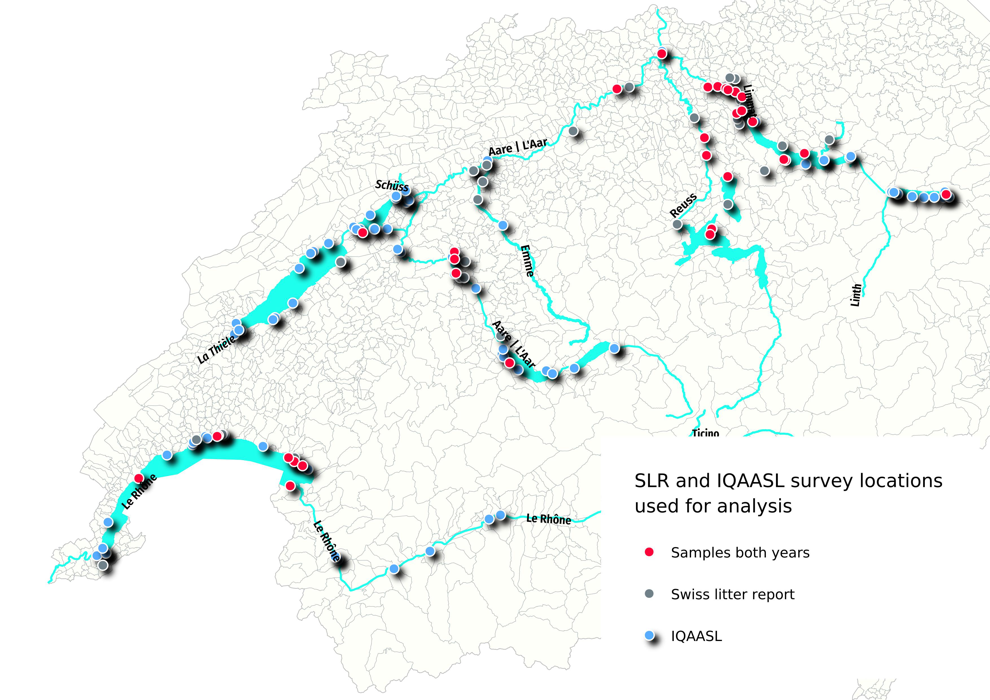

In [2]:
sut.display_image_ipython("resources/maps/slr_iqasl.jpeg", thumb=(1200, 700))

In [3]:
# make sure date is time stamp
survey_data["date"] = pd.to_datetime(survey_data["date"], format="%Y-%m-%d")

# get only the water features that were sampled in 2020
after_2020 = survey_data[survey_data["date"] >= "2020-01-01"].water_name_slug.unique()
a_data = survey_data[survey_data.water_name_slug.isin(after_2020)].copy()

# convert pcs-m to unit_value
a_data["pcs_m"] = (a_data.pcs_m * unit_value).astype("int")
a_data.rename(columns={"pcs_m":unit_label}, inplace=True)

# the date ranges of two projects
first_date_range = (a_data.date >= "2017-04-01")&(a_data.date <= "2018-03-31")
second_date_range = (a_data.date >= "2020-04-01")&(a_data.date <= "2021-03-31")

# a df for each set
slr_data = a_data[first_date_range].copy()
iqasl_data = a_data[second_date_range].copy()

# only use codes identified in the first project
these_codes = slr_data[slr_data.quantity > 0].code.unique()

# add a survey year column to each data set
iqasl_data["survey year"] = "2020"
slr_data["survey year"] = "2018"

# put the two sets of data back together
combined_data = pd.concat([iqasl_data, slr_data])
combined_data["length"] = (combined_data.quantity/combined_data[unit_label])*unit_value

# unique locations in both years
sdlocs = slr_data.location.unique()
iqs = iqasl_data.location.unique()

# locations common to both
both_years = list(set(sdlocs).intersection(iqs))

# locations specific to each year
just_2017 = [x for x in sdlocs if x not in iqs]
j_2020 = [x for x in iqs if x not in sdlocs]

# use only the codes identified in 2017, the protocol only called for certain MLW codes
df = combined_data[combined_data.code.isin(these_codes)].copy()

# scale the streets value
df["streets km"] = (df.streets/1000).round(1)

### Landnutzungsprofil der Erhebungsorte

Das Landnutzungsprofil sind die messbaren Eigenschaften, die geolokalisiert sind und aus den aktuellen Versionen von Statistique Suisse de la superficie {cite}`superficie` und swissTlmRegio {cite}`tlmregio`. extrahiert werden können. Das Landnutzungsprofil ist eine Schätzung der Art und des Umfangs der wirtschaftlichen Aktivität in der Nähe der Erhebungsorte. Die folgenden Werte wurden in einem Radius von 1500 m um jeden Erhebungsort berechnet:

1. \% der Fläche, die auf Gebäude entfällt 
2. \% der Fläche, die dem Wald vorbehalten ist 
3. \% der Fläche, die für Aktivitäten im Freien genutzt wird 
4. \% der Fläche, die der Landwirtschaft zugeschrieben wird
5. \% Länge aller Fahrbahnen in Metern 
6. \% Anzahl der Abflussschnittpunkte des Flusses 

Mit Stand vom 22. Juni waren die 2021,Landnutzungsdaten für Walensee nicht mehr aktuell. Walensse wurde geschätzt, indem die relevanten Kartenebenen visuell inspiziert und die Landnutzungsraten mit denen anderer Orte mit ähnlicher Bevölkerungszahl verglichen wurden. Einzelheiten zu dieser Berechnung und warum sie wichtig ist, finden Sie unte [_Landnutzungsprofil_](luseprofilede).

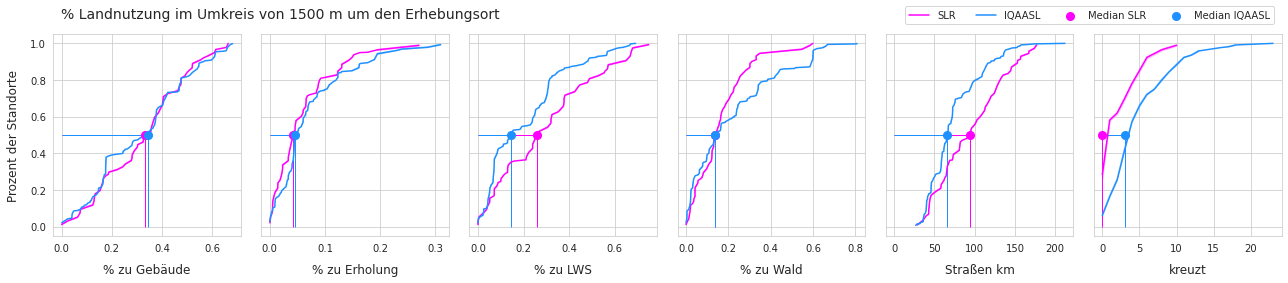

In [4]:
# !!walensee landuse is approximated by comparing the land use profile from similar locations!!
# the classification for that part of switzerland is incomplete for the current estimates
# the land use profile of wychely - brienzersee was used for walenstadt-wyss (more prairie, buildings less woods)
# the land use profile of grand-clos - lac-leman was used for other locations on walensee (more woods, less buildings, less praire and agg)
luse_wstdt = dfBeaches.loc["wycheley"][["population","% to buildings", "% to trans", "% to recreation", "% to agg", "% to woods"]]
estimate_luse = dfBeaches.loc["grand-clos"][["population","% to buildings", "% to trans", "% to recreation", "% to agg", "% to woods"]]
lu = sut.luse_ge
# seperate out the locations that aren"t walenstadt
wlsnsee_locs_not_wstdt = ["gasi-strand", "untertenzen", "mols-rocks", "seeflechsen", "seemuhlestrasse-strand", "muhlehorn-dorf", "murg-bad", "flibach-river-right-bank"]

for a_param in estimate_luse.index:
    df.loc[df.location.isin(wlsnsee_locs_not_wstdt), a_param] = estimate_luse[a_param]
    df.loc["walensee_walenstadt_wysse", a_param] = luse_wstdt[a_param]
    
dfdt = df.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# chart the distribtuion of survey results with respect to the land use profile
fig, axs = plt.subplots(1, len(luse_exp), figsize=(len(luse_exp)*3,4), sharey="row")

data=dfdt[(dfdt["survey year"] == "2018")].groupby(use_these_cols[:-2], as_index=False).agg({"p/100m":"sum", "quantity":"sum"})
data2=dfdt[(dfdt["survey year"] == "2020")].groupby(use_these_cols[:-2], as_index=False).agg({"p/100m":"sum", "quantity":"sum"})

for i, n in enumerate(luse_exp):
    ax=axs[i]
    
    # land use data for each project
    the_data = ECDF(data[n].values)       
    the_data2 = ECDF(data2[n].values)
    
    # the median value    
    the_median = np.median(data[n].values)
    median_two = np.median(data2[n].values)    
    
    # plot the curves
    sns.lineplot(x= the_data.x, y=the_data.y, ax=ax, color=this_palette["2018"], label="SLR")
    sns.lineplot(x=the_data2.x, y=the_data2.y, ax=ax, color=this_palette["2020"], label="IQAASL")
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color=this_palette["2018"],s=50, linewidth=2, zorder=100, label="Median SLR")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color=this_palette["2018"], linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color=this_palette["2018"], linewidth=1)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([median_two], 0.5, color=this_palette["2020"],s=50, linewidth=2, zorder=100, label="Median IQAASL")
    ax.vlines(x=median_two, ymin=0, ymax=0.5, color=this_palette["2020"], linewidth=1)
    ax.hlines(xmax=median_two, xmin=0, y=0.5, color=this_palette["2020"], linewidth=1)
    if i == 0:
        ax.get_legend().remove()
        ax.set_ylabel("Prozent der Standorte", **ck.xlab_k)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(lu[n], **ck.xlab_k)
    
handles, labels=ax.get_legend_handles_labels()

plt.subplots_adjust(top=.9)
plt.suptitle("% Landnutzung im Umkreis von 1500 m um den Erhebungsort", ha="left", x=0.05, y=.97, fontsize=14)    
plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(.99,.99), loc="upper right", ncol=4)

plt.show()

*__Oben__ Verteilung der Anzahl der Umfragen in Bezug auf das Landnutzungsprofil SLR - IQAASL* 

Die Stichprobenorte in der SLR hatten einen größeren Anteil an landwirtschaftlich genutzter Fläche und ein dichteres Straßennetz als die Orte in IQAASL. Der prozentuale Anteil der Wälder an der Gesamtfläche weicht nach dem Median ab. An diesem Punkt haben die Orte in IQAASL einen größeren Anteil an Wäldern im Vergleich zu SLR. 

Die Einwohnerzahl (nicht gezeigt) stammt aus statpop 2018 {cite}`statpop`. Die kleinste Einwohnerzahl betrug 442 und die größte 415.357. Mindestens 50% der Stichproben stammten aus Gemeinden mit einer Einwohnerzahl von 13.000 oder weniger. 

Wenn der prozentuale Anteil der Landwirtschaft an der Landnutzung ein Zeichen für Verstädterung ist, dann waren die untersuchten Gebiete im Jahr 2020 etwas städtischer als 2018. 

## Ergebnisse Seen und Flüsse

Betrachtet man nur die Seen und Flüsse, die in beiden Jahren Proben aufweisen, so wurden 2018 mehr Proben und Müll an weniger Orten gesammelt als 2020. Auf der Basis von Stücken pro Meter war der Median im Jahr 2020 jedoch größer. 

### Verteilung der Ergebnisse 2018 und 2020

*__Oben links:__ Gesamtwerte der Umfrage nach Datum. __Oben rechts:__ Median der monatlichen Gesamtzahl der Erhebungen. __Unten links:__ Anzahl der Stichproben in Bezug auf die Gesamtzahl der Erhebungen. __Unten rechts:__ empirische kumulative Verteilung der Gesamtzahlen der Erhebungen.*

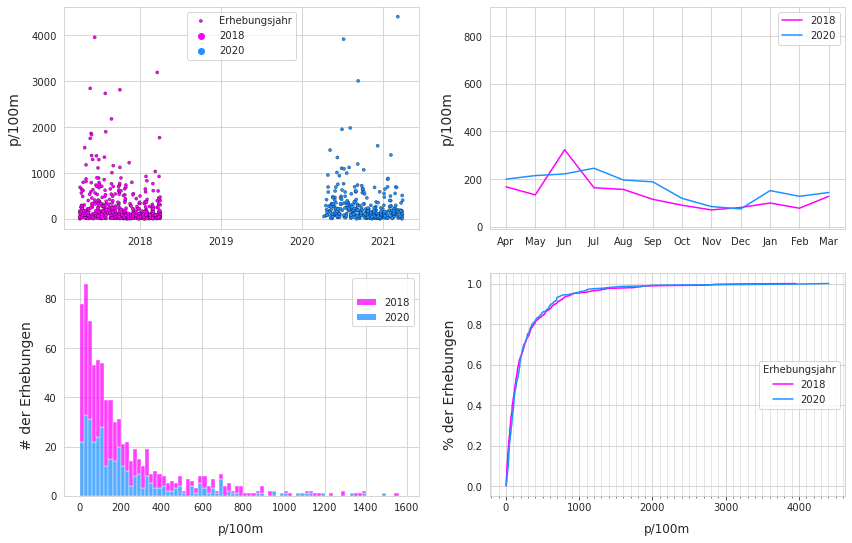

In [5]:
# group by survey and sum all the objects for each survey AKA: survey total
data=df.groupby(["survey year","water_name_slug","loc_date", "location", "date"], as_index=False)[unit_label].sum()
data["lakes"] = data.water_name_slug.isin(these_lakes)

# get the ecdf for both projects
ecdf_2017 = ECDF(data[data["survey year"] == "2018"][unit_label].values)
ecdf_2020 = ECDF(data[data["survey year"] == "2020"][unit_label].values)

# get the ecddf for the condition lakes in both years
l2017 = data[(data.water_name_slug.isin(these_lakes))&(data["survey year"] == "2018")].copy()
l2020 = data[(data.water_name_slug.isin(these_lakes))&(data["survey year"] == "2020")].copy()

ecdf_2017l = ECDF(l2017[unit_label].values)
ecdf_2020l = ECDF(l2020[unit_label].values)

# group by survey year and use pd.describe to get basic stats
som_1720 = data.groupby("survey year")[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720["total objects"] = som_1720.index.map(lambda x: df[df["survey year"] == x].quantity.sum())
som_1720["# locations"] = som_1720.index.map(lambda x: df[df["survey year"] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(sut.create_summary_table_index(unit_label, lang="DE")), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=["survey year"])

# pivot on survey year
combined_summary = c_s.pivot(columns="variable", index="survey year")

# change the index to date
data.set_index("date", inplace=True)

# get the median monthly value
monthly_2017 = data.loc[data["survey year"] == "2018"]["p/100m"].resample("M").median()

# change the date to the name of the month for charting
months_2017 = pd.DataFrame({"month":[dt.datetime.strftime(x, "%b") for x in monthly_2017.index], unit_label:monthly_2017.values})

# repeat for 2020
monthly_2020 = data.loc[data["survey year"] == "2020"]["p/100m"].resample("M").median()
months_2020 = pd.DataFrame({"month":[dt.datetime.strftime(x, "%b") for x in monthly_2020.index], unit_label:monthly_2020.values})

# set the date intervals for the chart
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
years = mdates.YearLocator()

# set a y limit axis:
the_90th = np.percentile(data["p/100m"], 95)

# chart that
fig, ax = plt.subplots(2,2, figsize=(14,9), sharey=False)

# set axs and lables
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel(unit_label, **ck.xlab_k14)
axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)
axone.set_xlabel(" ")

axtwo.set_xlabel(" ")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)
axtwo.set_ylim(-10, the_90th)

axthree.set_ylabel("# der Erhebungen", **ck.xlab_k14)
axthree.set_xlabel(unit_label, **ck.xlab_k)

axfour.set_ylabel("% der Erhebungen", **ck.xlab_k14)
axfour.set_xlabel(unit_label, **ck.xlab_k)

# histogram data:
data_long = pd.melt(data[["survey year", "loc_date", unit_label]],id_vars=["survey year","loc_date"], value_vars=(unit_label,), value_name="survey total")
data_long["year_bin"] = np.where(data_long["survey year"] == "2018", 0, 1)

# scatter plot of surveys both years
sns.scatterplot(data=data, x="date", y="p/100m", color="red", s=10, ec="black",label="Erhebungsjahr", hue="survey year", palette=this_palette, ax=axone)
axone.legend(loc="upper center")

# monthly median
sns.lineplot(data=months_2017, x="month", y=unit_label, color=this_palette["2018"], label=F"2018", ax=axtwo)
sns.lineplot(data=months_2020, x="month", y=unit_label, color=this_palette["2020"], label=F"2020", ax=axtwo)

# histogram
axthree = sns.histplot(data=data_long, x="survey total", hue="survey year", legend=True, stat="count", multiple="stack",palette=this_palette, ax=axthree, bins=[x*20 for x in np.arange(80)])
axthreel = axthree.get_legend()
axthreel.set_title(" ")

# empirical cumulative distribution
sns.lineplot(x=ecdf_2017.x, y=ecdf_2017.y, ax=axfour, color=this_palette["2018"], label="2018")
sns.lineplot(x=ecdf_2020.x, y=ecdf_2020.y, ax=axfour, color=this_palette["2020"], label="2020")

axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 

axfour.legend(loc="center right", title="Erhebungsjahr")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which="minor",linewidth=0.5)

plt.show()

### Zusammenfassende Daten und Materialtypen 2018 und 2020

*__Links:__ Zusammenfassung der Gesamtzahlen der Umfrage. __Rechts:__ Materialtypen*

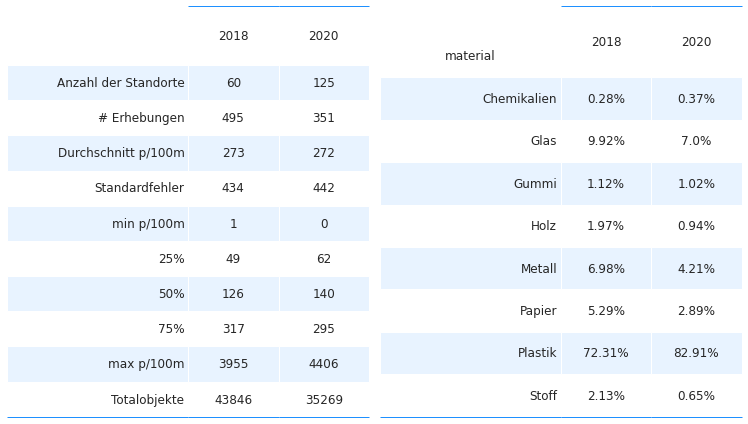

In [6]:
# format for printing
combined_summary.columns = combined_summary.columns.get_level_values(1)
col_rder = ['Anzahl der Standorte',
    '# Erhebungen',
    'Durchschnitt p/100m',
    'Standardfehler',
    'min p/100m',
    '25%',
    '50%',
    '75%',
    'max p/100m',
    'Totalobjekte'
]
cy = combined_summary[col_rder]
c = cy.T.reset_index()

c[["2018", "2020"]] = c[["2018", "2020"]].astype("int")

# material totals
mat_total = df.groupby(["survey year", "code"], as_index=False).quantity.sum()

# add material type:
mat_total["mat"] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the cumulative sum of material by category
mat_total = mat_total.groupby(["survey year", "mat"], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total["survey year"] == "2018", "yt"] = mat_total[mat_total["survey year"] == "2018"].quantity.sum()
mat_total.loc[mat_total["survey year"] == "2020", "yt"] = mat_total[mat_total["survey year"] == "2020"].quantity.sum()

# get % of total
mat_total["pt"] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total["pt"] = mat_total.pt.map(lambda x: F"{x}%")
mat_total["quantity"] = mat_total.quantity.map(lambda x: F"{x:,}")

# pivot and rename columns
m_t = mat_total[["survey year","mat", "quantity", "pt"]].pivot(columns="survey year", index="mat", values="pt").reset_index()
m_t.rename(columns={"mat":"material", "pt":"% of total"}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10.5,6))

axone = axs[0]
axtwo= axs[1]

# convenience func
sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)

a_table = sut.make_a_table(axone, c.values,  colLabels=c.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
a_table.get_celld()[(0,0)].get_text().set_text(" ")

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)
plt.tight_layout()
plt.show()

*Bei den Chemikalien handelt es sich hauptsächlich um Paraffin und beim Holz um verarbeitetes Holz*

#### Differenz der Mediane 2018 - 2020

Der beobachtete Unterschied der Mediane zwischen den beiden Projekten beträgt 14p/100m. Unterschiede dieser Größenordnung würden nicht wahrgenommen und könnten auf Zufall zurückzuführen sein. Um die Hypothese zu testen, wurde ein Permutationstest durchgeführt: 

> Nullhypothese: Der Median des Umfrageergebnisses von 2018 unterscheidet sich statistisch nicht von dem Median von 2020 und der beobachtete Unterschied ist auf Zufall zurückzuführen. 

> Alternativhypothese: Der Median des Umfrageergebnisses von 2018 unterscheidet sich statistisch von dem Median von 2020 und der beobachtete Unterschied ist nicht zufällig. 

*__Unten:__ Die Verteilung der Differenz der Mediane zwischen 2018 und 2020. Die Umfrageergebnisse wurden gemischt und in der Spalte des Umfragejahres 5.000 Mal als Stichprobe gezogen. Die Nullhypothese kann nicht verworfen werden, was das Argument stützt, dass die Medianwerte der Umfrageergebnisse von Jahr zu Jahr ungefähr gleich sind.*

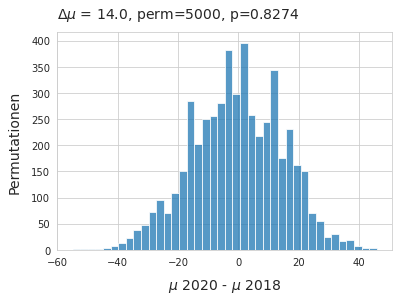

In [7]:
# data for testing
data=df.copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(["loc_date", "survey year"], as_index=False)[unit_label].sum()

# get the median from each year
observed_median = pre_shuffle.groupby("survey year")[unit_label].median()

# get the dif mu_2020 - mu_2017
observed_dif = observed_median.loc["2020"] - observed_median.loc["2018"]

# a place to store the sample statistics
new_medians=[]

# resampling:
for element in np.arange(5000):
    
    # shuffle the entire survey year column
    pre_shuffle["new_class"] = pre_shuffle["survey year"].sample(frac=1, replace=True).values
    # get the median for both "survey years"
    b=pre_shuffle.groupby("new_class").median()
    # get the change and store it    
    new_medians.append((b.loc["2018"] - b.loc["2020"]).values[0])

# calculate the empirical p
emp_p = np.count_nonzero(new_medians <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_medians, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel("Permutationen", **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()

### Die häufigsten Objekte

*__Unten:__ Die häufigsten Objekte sind die zehn mengenmäßig am häufigsten vorkommenden UND/ODER Objekte, die in mindestens 50% aller Erhebungen identifiziert wurden. Das sind 60-80% aller Objekte, die in einem bestimmten Erhebungszeitraum identifiziert wurden. Die am häufigsten vorkommenden Objekte sind nicht von Jahr zu Jahr die gleichen. Um die Veränderungen zu bewerten, werden nur die Objekte berücksichtigt, die in beiden Jahren am häufigsten vorkamen. __Links:__ häufigste Objekte 2018, __rechts:__ häufigste Objekte 2020.*


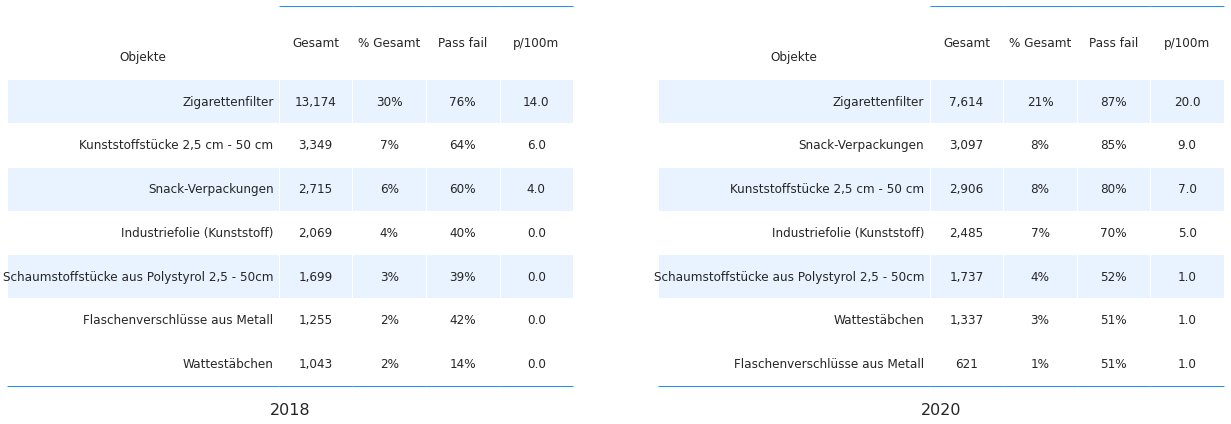

In [8]:
# code totals by project
c_totals = df.groupby(["survey year", "code"], as_index=False).agg({"quantity":"sum", "fail":"sum", unit_label:"median"})

# calculate the fail rate % of total for each code and survey year
for a_year in ["2018", "2020"]:
    c_totals.loc[c_totals["survey year"] == a_year, "fail rate"] = ((c_totals.fail/df[df["survey year"] == a_year].loc_date.nunique())*100).astype("int")
    c_totals.loc[c_totals["survey year"] == a_year, "% of total"] = ((c_totals.quantity/df[df["survey year"] == a_year].quantity.sum())*100).astype("int")
    
# get all the instances where the fail rate is > fail_rate
c_50 = c_totals.loc[c_totals["fail rate"] >= fail_rate]

# the top ten from each project
ten_2017 = c_totals[c_totals["survey year"] == "2018"].sort_values(by="quantity", ascending=False)[:10].code.unique()
ten_2020 = c_totals[c_totals["survey year"] == "2020"].sort_values(by="quantity", ascending=False)[:10].code.unique()

# combine the most common from each year with the top ten from each year
# most common 2017
mcom_2017 = list(set(c_50[c_50["survey year"]=="2018"].code.unique())|set(ten_2017))

# most common 2020
mcom_2020 = list(set(c_50[c_50["survey year"]=="2020"].code.unique())|set(ten_2020))

# the set of objects that were the most common in both years:
mcom = list(set(mcom_2017)&set(mcom_2020))

# get the data
com_2017 = c_totals[(c_totals["survey year"] == "2018")&(c_totals.code.isin(mcom))]
com_2020 = c_totals[(c_totals["survey year"] == "2020")&(c_totals.code.isin(mcom))]

# format values for table
table_data = []
chart_labels = ["2018", "2020"]
for i, som_data in enumerate([com_2017, com_2020]):
    som_data = som_data.set_index("code")
    som_data.sort_values(by="quantity", ascending=False, inplace=True)
    som_data["item"] = som_data.index.map(lambda x: code_description_map.loc[x])
    som_data["% of total"] = som_data["% of total"].map(lambda x: F"{int(x)}%")
    som_data["quantity"] = som_data.quantity.map(lambda x: F"{int(x):,}")
    som_data["fail rate"] = som_data["fail rate"].map(lambda x: F"{int(x)}%")
    som_data[unit_label] = som_data[unit_label].map(lambda x: F"{round(x,2)}")    
    table_data.append({chart_labels[i]:som_data})

# the columns needed
cols_to_use = {"item":"Objekte","quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"Pass fail", unit_label:unit_label}

fig, axs = plt.subplots(1,2, figsize=(17.2,10*.6))

for i,this_table in enumerate(table_data):
    this_ax = axs[i]
    
    sut.hide_spines_ticks_grids(this_ax)
    the_first_table_data = this_ax.table(table_data[i][chart_labels[i]][cols_to_use.keys()].values,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])
    a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_data[i][chart_labels[i]][cols_to_use.keys()].values,list(cols_to_use.values()), this_palette["2020"])
    this_ax.set_xlabel(chart_labels[i], fontsize=16, labelpad=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()

plt.close()

## Ergebnisse Seen 2018 und 2020

Die folgenden Seen wurden in beiden Projektjahren beprobt:

1. Zurichsee
2. Bielersee
3. Neuenburgersee
4. Walensee
5. Lac Léman
6. Thunersee

Bei der Betrachtung der sechs Seen (oben) gab es 2020 mehr Proben und Standorte und größere Mengen an gesammeltem Abfall, aber sowohl der Median als auch der Durchschnitt waren im Vergleich zu 2018 niedriger.  

In [9]:
# a df with just the lakes of interest
lks_df = df[df.water_name_slug.isin(these_lakes)].copy()

# a month column
lks_df["month"] = lks_df.date.dt.month

# survey totals
lks_dt = lks_df.groupby(["survey year", "water_name_slug","loc_date","date", "month"], as_index=False)[unit_label].sum()

# locations in both years
com_locs_df = lks_df[lks_df.location.isin(both_years)].copy()

# nsamps from locations in both years
nsamps_com_locs = com_locs_df[com_locs_df["survey year"] == "2020"].groupby(["location"], as_index=True).loc_date.nunique()

# common locations surveyed in 2020
com_locs_20 = com_locs_df[com_locs_df["survey year"] == "2020"].location.unique()

# locations surveyed in 2020
locs_lakes = lks_df[lks_df["survey year"] == "2020"].location.unique()

*__Oben links:__ Umfragesummen nach Datum, __oben rechts:__ Median der monatlichen Umfragesumme, __unten links:__ Anzahl der Stichproben in Bezug auf die Umfragesumme, __unten rechts:__ empirische kumulative Verteilung der Umfragesummen* 

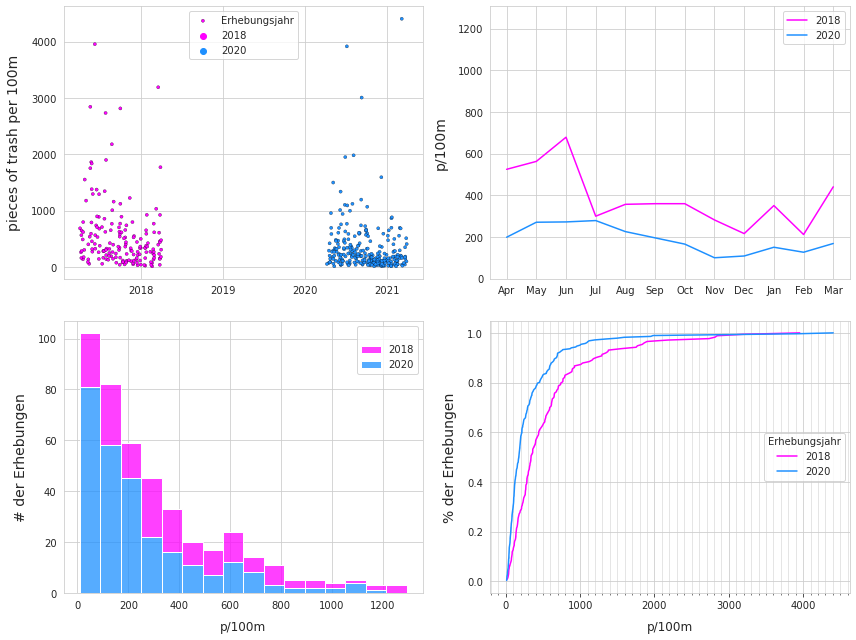

In [10]:
data=lks_df.groupby(["survey year","loc_date", "date"], as_index=False)[unit_label].sum()
data.set_index("date", inplace=True)

# the empirical distributions for each year
ecdf_2017 = ECDF(data[data["survey year"] == "2018"][unit_label].values)
ecdf_2020 = ECDF(data[data["survey year"] == "2020"][unit_label].values)

# get the x,y vals for each year
ecdf_2017_x, ecdf_2017_y = ecdf_2017.x, ecdf_2017.y
ecdf_2020_x, ecdf_2020_y = ecdf_2020.x, ecdf_2020.y

the_90th = np.percentile(data[unit_label], 95)

# the monthly plots
just_2017 = data[data["survey year"] == "2018"][unit_label].resample("M").median()
monthly_2017 = pd.DataFrame(just_2017)
monthly_2017.reset_index(inplace=True)
monthly_2017["month"] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))

just_2020 = data[data["survey year"] == "2020"][unit_label].resample("M").median()
monthly_2020 = pd.DataFrame(just_2020)
monthly_2020.reset_index(inplace=True)
monthly_2020["month"] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

# long form data for histogram
data_long = pd.melt(data[["survey year", "p/100m"]],id_vars=["survey year"], value_vars=("p/100m",), value_name="survey total")
data_long["year_bin"] = np.where(data_long["survey year"] == "2018", 0, 1)
data_long = data_long[data_long["survey total"] < the_90th].copy()

fig, ax = plt.subplots(2,2, figsize=(12,9), sharey=False)

# set axs and labels
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)
axone.set_xlabel(" ")

axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)

axtwo.set_xlabel(" ")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

axthree.set_ylabel("# der Erhebungen", **ck.xlab_k14)
axthree.set_xlabel(unit_label, **ck.xlab_k)
axtwo.set_ylim(0, the_90th)

axfour.set_ylabel("% der Erhebungen", **ck.xlab_k14)
axfour.set_xlabel(unit_label, **ck.xlab_k)

# scatter plot of surveys both years
sns.scatterplot(data=data, x="date", y="p/100m", color="red", s=10, ec="black",label="Erhebungsjahr", hue="survey year", palette=this_palette, ax=axone)
axone.legend(loc="upper center")

# monthly median
sns.lineplot(data=monthly_2017, x="month", y=unit_label, color=this_palette["2018"], label=F"2018", ax=axtwo)
sns.lineplot(data=monthly_2020, x="month", y=unit_label, color=this_palette["2020"], label=F"2020", ax=axtwo)

# histogram of survey results
sns.histplot(data=data_long, x="survey total", hue="survey year", stat="count", multiple="stack", palette=this_palette, ax=axthree)
axthreel = axthree.get_legend()
axthreel.set_title(" ")

# ecdfs
sns.lineplot(x=ecdf_2017_x, y=ecdf_2017_y, ax=axfour, color=this_palette["2018"], label="2018")
sns.lineplot(x=ecdf_2020_x, y=ecdf_2020_y, ax=axfour, color=this_palette["2020"], label="2020")

axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 
axfour.legend(loc="center right", title="Erhebungsjahr")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which="minor",linewidth=0.5)

axone.legend(loc="upper center")

plt.tight_layout()
plt.show()

*__Links:__ Zusammenfassung der Gesamterhebung, rechts: Materialtype*

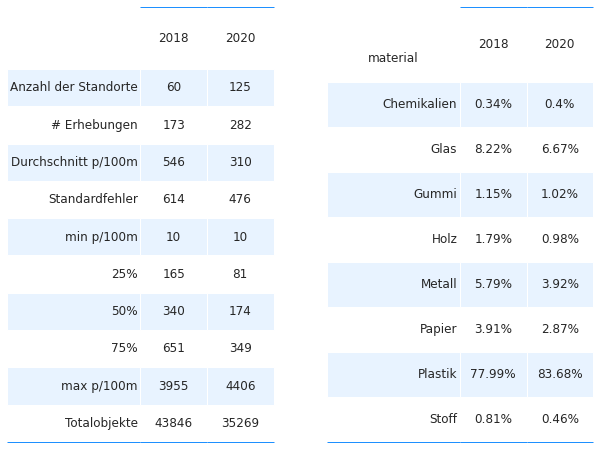

In [11]:
# group by survey year and use pd.describe to get basic stats
som_1720 = lks_dt.groupby("survey year")[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720["total objects"] = som_1720.index.map(lambda x: df[df["survey year"] == x].quantity.sum())
som_1720["# locations"] = som_1720.index.map(lambda x: df[df["survey year"] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(sut.create_summary_table_index(unit_label, lang="DE")), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=["survey year"])

# pivot on survey year
combined_summary = c_s.pivot(columns="variable", index="survey year")

# format for printing
combined_summary.columns = combined_summary.columns.get_level_values(1)
col_rder = ['Anzahl der Standorte',
    '# Erhebungen',
    'Durchschnitt p/100m',
    'Standardfehler',
    'min p/100m',
    '25%',
    '50%',
    '75%',
    'max p/100m',
    'Totalobjekte'
]
cy = combined_summary[col_rder]
c = cy.T.reset_index()
c[["2018","2020"]] =  c[["2018", "2020"]].astype("int")

# material totals
mat_total = lks_df.groupby(["survey year", "code"], as_index=False).quantity.sum()

# add material type:
mat_total["mat"] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the most common codes for each year
mat_total = mat_total.groupby(["survey year", "mat"], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total["survey year"] == "2018", "yt"] = mat_total[mat_total["survey year"] == "2018"].quantity.sum()
mat_total.loc[mat_total["survey year"] == "2020", "yt"] = mat_total[mat_total["survey year"] == "2020"].quantity.sum()

# get % of total
mat_total["pt"] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total["pt"] = mat_total.pt.map(lambda x: F"{x}%")
mat_total["quantity"] = mat_total.quantity.map(lambda x: F"{x:,}")

m_t = mat_total[["survey year","mat", "quantity", "pt"]].pivot(columns="survey year", index="mat", values="pt").reset_index()
m_t.rename(columns={"mat":"material", "pt":"% of total"}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10.5,8))

axone = axs[0]
axtwo= axs[1]

sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)

# summary data table
a_table = sut.make_a_table(axone, c.values,  colLabels=c.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
a_table.get_celld()[(0,0)].get_text().set_text(" ")

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)

plt.show()

### Seen: Die häufigsten Objekte aus 2018

*__Unten:__ Die häufigsten Objekte waren 71% aller gezählten Objekte im Jahr 2018 gegenüber 60% im Jahr 2020. Zigarettenfilter und zerbrochene Plastikteile wurden 2018 fast doppelt so häufig gezählt wie 2020.* 

*Lakes: key indicators of the most common objects 2018 - 2020*

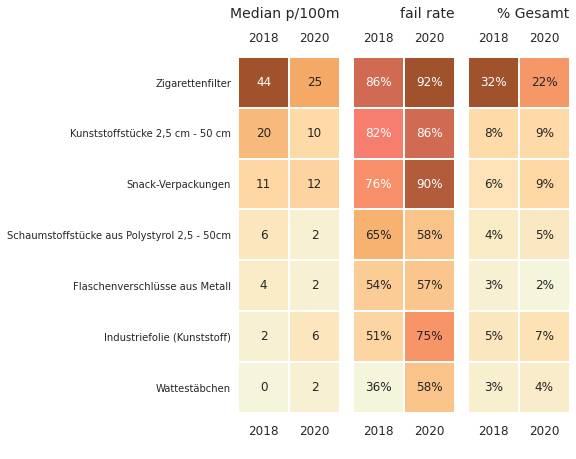

In [12]:
# compare the key indicators of the most common objects
lks_codes = lks_df[lks_df.code.isin(mcom)].copy()
lks_codes = lks_df[lks_df.code.isin(mcom)].groupby(["code", "survey year"], as_index=False).agg({unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"})

# get fail rate and % of total
for a_year in ["2020", "2018"]:
    lks_codes.loc[lks_codes["survey year"] == a_year, "fail rate"] = lks_codes.fail/lks_df[lks_df["survey year"]==a_year].loc_date.nunique()
    lks_codes.loc[lks_codes["survey year"] == a_year, "% of total"] = lks_codes.quantity/lks_df[lks_df["survey year"]==a_year].quantity.sum()

# pivot on the survey year column and keep all the values
pivot_2017_2020 = lks_codes.pivot(columns="survey year", values=[unit_label, "fail rate", "% of total"], index="code")

# map description to code
pivot_2017_2020["Item"] = pivot_2017_2020.index.map(lambda x: code_description_map.loc[x])

# set index and sort
pivot_2017_2020.set_index("Item", inplace=True, drop=True)
pivot_2017_2020.sort_values(by=(unit_label,"2018"), ascending=False, inplace=True)

# plot that
fig = plt.figure(figsize=(8, 12))

# use gridspec to position
spec = GridSpec(ncols=8, nrows=2, figure=fig)
axone = fig.add_subplot(spec[:,1:3])
axtwo = fig.add_subplot(spec[:,3:5])
axthree = fig.add_subplot(spec[:,5:7])

# get an order to assign each ax
an_order = pivot_2017_2020["p/100m"].sort_values(by="2018", ascending=False).index

# index axtwo and and axthree to axone
axtwo_data = pivot_2017_2020["fail rate"].sort_values(by="2018", ascending=False).reindex(an_order)
axthree_data = pivot_2017_2020["% of total"].sort_values(by="2018", ascending=False).reindex(an_order)

# pieces per meter

sns.heatmap(pivot_2017_2020[unit_label], cmap=cmap2, annot=True, fmt=".0f", annot_kws={"fontsize":12},  ax=axone, square=True, cbar=False, linewidth=.05,  linecolor="white")
axone.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axone.set_xlabel(" ")
axone.set_title("Median p/100m",**ck.title_k14r)

# fail rate
sns.heatmap(pivot_2017_2020["fail rate"], cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", ax=axtwo, square=True,  cbar=False, linewidth=.05,  linecolor="white")
axtwo.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axtwo.tick_params(labelleft=False, left=False)
axtwo.set_xlabel(" ")
axtwo.set_title("fail rate", **ck.title_k14r)

# percent of total
sns.heatmap(pivot_2017_2020["% of total"], cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", ax=axthree, square=True,  cbar=False, linewidth=.05,  linecolor="white")
axthree.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axthree.tick_params(labelleft=False, left=False)
axthree.set_xlabel(" ")
axthree.set_title("% Gesamt", **ck.title_k14r)

for anax in [axone, axtwo, axthree]:
    anax.set_ylabel("")

plt.subplots_adjust(wspace=0.3)

plt.show()

### Differenz der durchschnittlichen Erhebungssumme

Bei der Betrachtung nur der Seen ist die Differenz der Mediane umgekehrt, es wurde 2020 weniger Abfall beobachtet als 2018 und die Differenz der Mittelwerte ist viel größer zugunsten von 2018. Das deutet darauf hin, dass auf der Ebene der Seen ein Rückgang der beobachteten Mengen zu verzeichnen war. 

> Nullhypothese: Der Mittelwert der Umfrageergebnisse für Seen aus dem Jahr 2018 unterscheidet sich statistisch nicht von dem Mittelwert für 2020. Der beobachtete Unterschied ist auf Zufall zurückzuführen. 

> Zweite Hypothese: Der Mittelwert der Umfrageergebnisse für die Seen im Jahr 2018 ist nicht derselbe wie im Jahr 2020. Der beobachtete Unterschied in den Stichproben ist signifikant. 

*__Unten:__ Die Verteilung der Differenz der Mittelwerte zwischen den beiden Stichprobenzeiträumen. Die Umfrageergebnisse wurden gemischt und in der Spalte des Umfragejahres 5.000 Mal als Stichprobe gezogen. Die Nullhypothese konnte verworfen werden, was die anfängliche Beobachtung stützt, dass im Jahr 2020 weniger beobachtet wurde als 2018.*

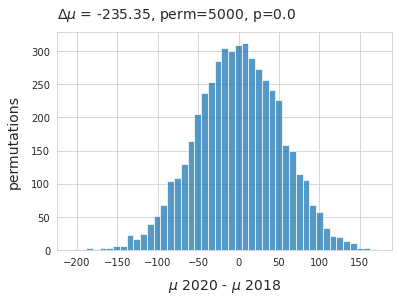

In [13]:
# data for testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(["survey year", "loc_date"], as_index=False)[unit_label].sum()

# get the mean for each survey year
observed_mean = pre_shuffle.groupby("survey year")[unit_label].mean()

# get the diff
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]

new_means=[]
# resampling:
for element in np.arange(5000):
    
    # shuffle the survey year column
    pre_shuffle["new_class"] = pre_shuffle["survey year"].sample(frac=1).values
    # get the means for both years
    b=pre_shuffle.groupby("new_class").mean()
    # get the change and store it
    new_means.append((b.loc["2020"] - b.loc["2018"]).values[0])

# calculate p
emp_p = np.count_nonzero(new_means <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel("permutations", **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()

### Differenz der durchschnittlichen Erhebungssumme

Bei der Betrachtung nur der Seen ist die Differenz der Mediane umgekehrt, es wurde 2020 weniger Abfall beobachtet als 2018 und die Differenz der Mittelwerte ist viel größer zugunsten von 2018. Das deutet darauf hin, dass auf der Ebene der Seen ein Rückgang der beobachteten Mengen zu verzeichnen war. 

> Nullhypothese: Der Mittelwert der Umfrageergebnisse für Seen aus dem Jahr 2018 unterscheidet sich statistisch nicht von dem Mittelwert für 2020. Der beobachtete Unterschied ist auf Zufall zurückzuführen. 

> Zweite Hypothese: Der Mittelwert der Umfrageergebnisse für die Seen im Jahr 2018 ist nicht derselbe wie im Jahr 2020. Der beobachtete Unterschied in den Stichproben ist signifikant. 

*__Unten:__ Die Verteilung der Differenz der Mittelwerte zwischen den beiden Stichprobenzeiträumen. Die Umfrageergebnisse wurden gemischt und in der Spalte des Umfragejahres 5.000 Mal als Stichprobe gezogen. Die Nullhypothese konnte verworfen werden, was die anfängliche Beobachtung stützt, dass im Jahr 2020 weniger beobachtet wurde als 2018.* 

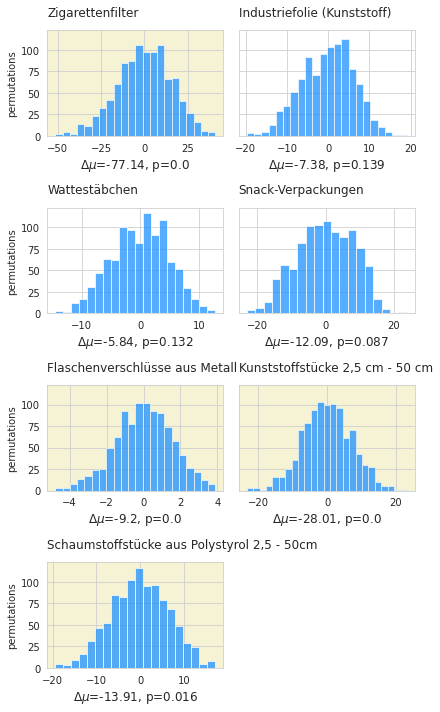

In [14]:
# data testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# # the common codes from both years
# common_codes_both_years = list(set([*mcom_2017, *mcom_2020]))

# data to resample
pre_shuffle = data[data.code.isin(mcom)].groupby(["survey year", "loc_date", "code"], as_index=False)[unit_label].sum()

# the observed mean from each year
observed_mean = pre_shuffle.groupby(["survey year", "code"])[unit_label].mean()

# get the differences from one year to the next: check the inverse
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]
inv_diff = observed_mean.loc["2018"] - observed_mean.loc["2020"]

# number of shuffles
perms = 1000

new_means=[]
# resample
for a_code in mcom:
    
    # store the test statisitc
    cdif = []

    c_data = pre_shuffle[pre_shuffle.code == a_code].copy()
    for element in np.arange(perms):
        # shuffle labels
        c_data["new_class"] = c_data["survey year"].sample(frac=1).values
        b=c_data.groupby("new_class").mean()
        cdif.append((b.loc["2020"] - b.loc["2018"]).values[0])

    emp_p = np.count_nonzero(cdif <= (observed_dif.loc[a_code])) / perms
   
    # store that result
    new_means.append({a_code:{"p":emp_p,"difs":cdif}})    

# chart the results
fig, axs = plt.subplots(4,2, figsize=(6,10), sharey=True)

for i,code in enumerate(mcom):
    
    # set up the ax
    row = int(np.floor((i/2)%4))
    col =i%2
    ax=axs[row, col]
    
    # data for charts
    data = new_means[i][code]["difs"]
    
    # pvalues
    p=new_means[i][code]["p"]
   
    
    # set the facecolor based on the p value    
    if p < 0.05:
        ax.patch.set_facecolor("palegoldenrod")
        ax.patch.set_alpha(0.5)        
    # plot that    
    sns.histplot(data, ax=ax, color=this_palette["2020"])
    
    ax.set_title(code_description_map.loc[code], **ck.title_k)
    ax.set_xlabel(F"$\u0394\mu$={np.round(observed_dif.loc[code], 2)}, p={new_means[i][code]['p']}", fontsize=12)
    ax.set_ylabel("permutations")

# hide the unused axs
sut.hide_spines_ticks_grids(axs[3,1])

# get some space for xaxis label
plt.subplots_adjust(hspace=0.25)

plt.tight_layout()
plt.show()

In [15]:
small = lks_df[lks_df.code.isin([ "G20", "G21", "G22", "G23"])].groupby(["code", "survey year"], as_index=False).agg({"quantity":"sum", "p/100m":"median"})
ttl = combined_data.groupby("survey year").quantity.sum()
small.loc[small["survey year"] == "2018", "p_t"] = small.quantity/ttl.loc["2018"]
small.loc[small["survey year"] == "2020", "p_t"] = small.quantity/ttl.loc["2020"]
# print(small.groupby(["survey year","code"]).sum())
# print(small.groupby(["survey year"]).sum())

### Landnutzungsprofil: Spearmans rangierte Korrelation

Die Merkmale der Landnutzung wurden zuvor berechnet, um die Erhebungsorte zu vergleichen. Um die statistische Signifikanz der Landnutzung auf die Ergebnisse der Strandabfalluntersuchung zu testen, wurden die Gesamtzahlen und Standorte beider Projekte als eine Gruppe betrachtet. Die Umfrageergebnisse der häufigsten Objekte wurden mit den gemessenen Landnutzungsmerkmalen verglichen.  

Spearman"s $\rho$ orSpearmans Rangkorrelationskoeffizient ist ein nichtparametrischer Test der Rangkorrelation zwischen zwei Variablen {cite}`defspearmans` {cite}`spearmansexplained`. Die Testergebnisse werden bei p<0,05 und 454 Stichproben ausgewertet. Zur Implementierung des Tests wird SciPy verwendet {cite}`impspearmans`.

1. rot/rose ist eine positive Assoziation: p<0.05 AND $\rho$ > 0
2. gelb ist eine negative Assoziation: p<0.05 AND $\rho$ < 0
3. weißen Medianen, die p>0,05 sind, gibt es keine statistische Grundlage für die Annahme eines Zusammenhangs

An association suggests that survey totals for that object will change in relation to the amount of space attributed to that feature, or in the case of roads or river intersections, the quantity. The magnitude of the relationship is not defined and any association is not linear.

*__Unten:__ Eine Assoziation deutet darauf hin, dass sich die Erhebungssummen für das betreffende Objekt im Verhältnis zu der diesem Merkmal zugewiesenen Fläche oder - im Falle von Straßen oder Flusskreuzungen - der Menge ändern. Das Ausmaß der Beziehung ist nicht definiert, und jede Assoziation ist nicht linear.*

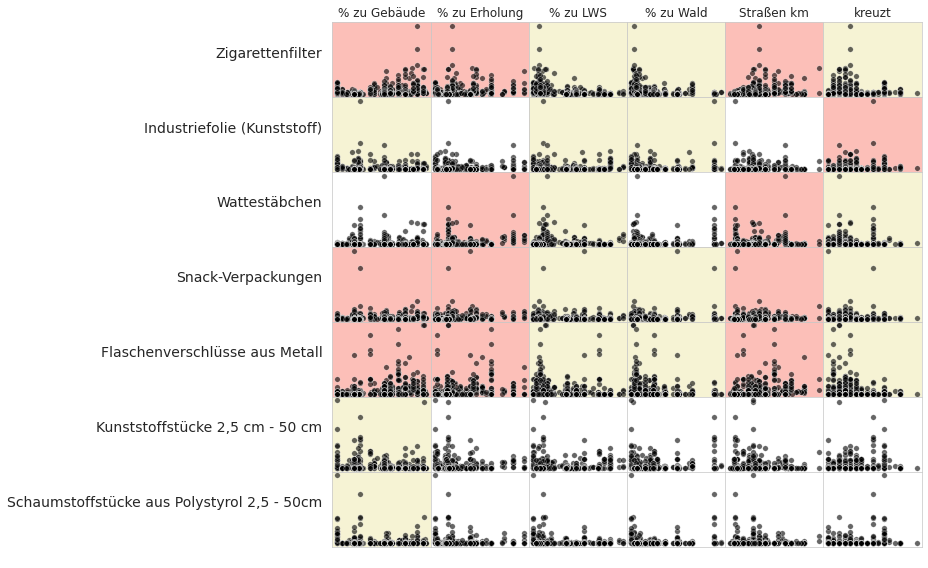

In [16]:
corr_data = lks_df[(lks_df.code.isin(mcom))].copy()

# keys to the column names
some_keys = {
    "% to buildings":"lu_build",
    "% to agg":"lu_agg",
    "% to woods":"lu_woods",
    "% to recreation":"lu_rec",
    "% to trans":"lu_trans",
    "% to meadow":"lu_m",
    "str_rank":"lu_trans"
}

fig, axs = plt.subplots(len(mcom),len(luse_exp), figsize=(len(luse_exp)+7,len(mcom)+1), sharey="row")

for i,code in enumerate(mcom):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        # each grid is its own axis with a scatterplot
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{sut.luse_ge[n]}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha="right", **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        _, corr, a_p = sut.make_plot_with_spearmans(data, ax, n)
        
        # assign the facecolor based on the value of p and rho
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor("salmon")
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor("palegoldenrod")
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

#### Interpretieren Sie Spearmans $\rho$

Eine positive Assoziation deutet darauf hin, dass Landnutzungsattribute oder -merkmale die Untersuchungsergebnisse im Vergleich zu anderen Standorten erhöhen. Dies kann auf eine Kovarianz von Attributen zurückzuführen sein. In jedem Fall __ist eine positive Assoziation ein Signal dafür, dass die Untersuchungsorte in der Nähe einer Akkumulationszone oder einer Quelle liegen.__ Dieses Signal sollte zusammen mit den anderen Schlüsselindikatoren von Untersuchungsstandorten mit ähnlichen Landnutzungsprofilen bewertet werden. Im Allgemeinen können Orte, die die Kriterien erfüllen, sowohl als Quelle als auch als Akkumulationsgebiet für alle Objekte, die positiv assoziiert sind, betrachtet werden. 

Eine negative Assoziation bedeutet, dass das Landnutzungsmerkmal oder -attribut die Akkumulation des Objekts nicht erleichtert. Dieses Ergebnis ist für landwirtschaftliche und bewaldete Gebiete auf nationaler Ebene üblich. __Eine negative Assoziation ist ein Signal dafür, dass die Orte keine Akkumulationszone für das Objekt sind__. 

Wenige oder keine Assoziationen bedeuten, dass die Landnutzungsmerkmale keinen Einfluss auf die Anhäufung dieses Objekts hatten. Die Umfrageergebnisse zu den häufigsten Objekten ohne oder mit wenigen Assoziationen lassen sich in zwei Kategorien einteilen: 

1. Allgegenwärtig: hohe Ausfallrate, hohe Stückzahl pro Meter. Im gesamten Untersuchungsgebiet in gleichbleibender Häufigkeit gefunden, unabhängig von der Landnutzung 
2. Vorübergehend: geringe Ausfallrate, hohe Menge, hohe Stückzahl pro Meter, wenige Verbände. Gelegentlich in großen Mengen an bestimmten Orten gefunden  in large quantities at specific locations

## Fazit

__Per Saldo keine Änderung__ 

Die zusammenfassenden Statistiken und die Ergebnisse des Tests zur Differenz der Mediane deuten darauf hin, dass es auf nationaler Ebene keine statistisch messbare Veränderung von einem Projekt zum nächsten gab. Der 95%ige KI des Medianwertes der Umfrage im Jahr 2020 lag bei 137 - 188p/100m (Abschnitt Berechnung der Basislinien). Das Medianergebnis für 2018 lag bei 125p/100m mit einem CI von 112p/100m bis 146p/100m, was die untere Grenze des Medians von 2020 einschließt. __Die Differenz der Mittelwerte für die häufigsten Objekte deutet jedoch auf ein realistischeres und dynamischeres Ergebnis hin:__

Es gab einen statistisch signifikanten Rückgang bei vier der sieben häufigsten Objekte aus beiden Jahren __Liste 1:__

1. There was a statistically significant decrease in four of seven most common objects from both years:
   * Zigarettenfilter
   * Flaschenverschlüsse aus Metall
   * Kunststofffragmente > 2,5 cm
   * Fragmente aus Schaumstoff > 2,5 cm 
  
Der Rückgang bei Tabak und Flaschenverschlüssen könnte mit den pandemischen Einschränkungen im Jahr 2020 zusammenhängen. Die Ergebnisse deuten darauf hin, dass der wahrgenommene lokale Rückgang der Abfallmengen höchstwahrscheinlich das Ergebnis eines allgemeinen Rückgangs der Nutzung und nicht einer umfassenden Verhaltensänderung war. Folglich werden die Umfrageergebnisse für Gegenstände der Liste 1 höchstwahrscheinlich wieder auf das Niveau von 2018 zurückkehren, wenn die pandemiebedingten Beschränkungen gelockert werden und sich die Nutzungsmuster wieder normalisieren. 

Die Rückgänge bei fragmentierten Schaumstoffen und geschäumten Kunststoffen sind wahrscheinlich auf einen Unterschied in den Protokollen zwischen den beiden Jahren zurückzuführen.  

### Protokolle Angelegenheit

Es gab einen entscheidenden Unterschied zwischen den beiden Projekten: 

* Das 2020-Protokoll zählt alle sichtbaren Objekte und klassifiziert Fragmente nach Größe 
* Das Protokoll von 2018 beschränkte die Anzahl der Objekte auf Gegenstände, die größer oder gleich 2,5 cm lang waren

Die Gesamtmenge der im Jahr 2020 gesammelten Plastikteile beträgt 7.400 oder 18p/100m und 5.563 oder 5p/100m Schaumstofffragmente. Im Jahr 2020 wurden 3.662 Plastikteile zwischen 0,5 und 2,5 cm entfernt, was der Gesamtmenge von 2018 entspricht. Das Gleiche gilt für Schaumstoffteile zwischen 0,5 und 2,5 cm, siehe [_Seen und Flüsse_](allsurveysde). 

Der Unterschied im Protokoll und die Ergebnisse von lassen2020 Zweifel an der Wahrscheinlichkeit eines Rückgangs von fragmentierten Kunststoffen und geschäumten Kunststoffen von 2018 bis 2020 aufkommen. Geschäumte Kunststoffe und fragmentierte Kunststoffe sind Gegenstände, deren ursprüngliche Verwendung unbekannt ist, aber das Material kann unterschieden werden. __Fragmentierte Kunststoffe und Schaumstoffe, die größer als 0,5 cm sind, machen 27 % der gesamten Erhebungsergebnisse für die Seen im Jahr 2020 aus.__ Studien im Maas-/Rheindelta zeigen, dass diese kleinen, fragmentierten Objekte einen großen Teil des Gesamtaufkommens ausmachen {cite}`meuserhine`.

Wenn Sie den Vermessungsingenieuren erlauben, eine breitere Palette von Objektcodes zu verwenden, erhöht sich die Genauigkeit der Gesamtzahl der erfassten Objekte und es lassen sich zusätzliche Ebenen zur Unterscheidung ähnlicher Materialien einrichten. Expandiertes Polystyrol zum Beispiel ist ein Objekt, das leicht zersplittert. Ob die Vermesser einige größere Stücke > 20 cm oder Tausende von Stücken < 10 mm finden, ist ein wichtiges Detail, wenn das Ziel darin besteht, diese Objekte in der Umwelt zu reduzieren.

__Geringere Kosten und besserer Zugang__ sind ein weiteres Ergebnis eines harmonisierten Protokolls. Die vom SLR und IQAASL angewandten Verfahren waren fast identisch, abgesehen von der Größenbeschränkung kann man davon ausgehen, dass die Proben unter ähnlichen Bedingungen gesammelt wurden. Die SLR-Daten liefern die Ergebnisse von über 1.000 Beobachtungen von etwa 150 Personen und die IQAASL-Daten liefern die Ergebnisse von 350 Beobachtungen von etwa 10 Personen. Beide Methoden haben Schwächen und Stärken, die sehr unterschiedliche Themen ansprechen: 

* Erfahrung des Vermessungsingenieurs 
* Konsistenz der Umfrageergebnisse 
* Aufsicht 
* beabsichtigte Verwendung der Daten 
* Zuweisung von Ressourcen 

All diese Themen sollten bei jedem Projekt berücksichtigt werden, ebenso wie der Umgang mit den Daten. Ungeachtet der Unterschiede konnten wir auf dem vom SLR vorgeschlagenen Modell aufbauen und zu den gemeinsamen Erfahrungen beitragen. 

### Plastikdeckel

1. Kunststoffdeckel werden bei der Zählung in drei Kategorien eingeteilt: 
2. Essen, Trinken 
3. Chemie/Haushalt  
4. unbekannt 

Als Gruppe machen Kunststoffdeckel 2 % der gesamten Objekte im Jahr 2018 und 3 % im Jahr 2020 aus. Getränkedeckel machten ~51% aller gefundenen Deckel im Jahr 2018 aus, 45% im Jahr 2020. Auf der Basis von Stücken pro Meter gab es eine Abnahme der Menge an Getränkedeckeln und eine Zunahme von Nicht-Getränkedeckeln von 2018 - 2020. 

### Landnutzungsprofil

Das Flächennutzungsprofil für jeden Standort wurde unter Verwendung derselben Daten für beide Jahre berechnet. Wenn die Umfrageergebnisse aus beiden Jahren als Gruppe betrachtet werden, unterstützen die Ergebnisse von Spearmans 𝜌 die SLR-Schlussfolgerungen im Jahr 2018, dass die Umfrageergebnisse in städtischen und vorstädtischen Umgebungen erhöht waren, und dies galt auch für 2020. Gleichzeitig war die in [Das Flächennutzungsprofil](luseprofilede) festgestellte Allgegenwärtigkeit von zerkleinerten Kunststoffen, Industriefolien und Schaumstoffen im Jahr 2018 wahrscheinlich vorherrschend. 

Bei den Flächen, die Freizeitaktivitäten zugeschrieben werden, handelt es sich um Orte in der Nähe des Erhebungsortes, die dazu bestimmt sind, Gruppen von Menschen für verschiedene Aktivitäten zu beherbergen. Die positive Assoziation von Tabak und Lebensmitteln/Getränken mit diesem Flächenattribut könnte als Ergebnis eines vorübergehenden Anstiegs der Bevölkerung in der Nähe des Untersuchungsgebiets interpretiert werden. 

### Schlussfolgerungen

Die Proben aus beiden Projekten wurden an Orten entnommen, in einigen Fällen am selben Ort, die ein ähnliches Niveau an Infrastruktur und wirtschaftlicher Entwicklung aufwiesen. Bei beiden Projekten wurde ein gemeinsames Protokoll verwendet. Die Proben wurden von zwei verschiedenen Gruppen entnommen und von zwei verschiedenen Verbänden verwaltet. 

Von 2018 bis 2020 gab es eine statistisch signifikante Veränderung, nämlich einen Rückgang der Anzahl der Objekte, die direkt mit dem Verhalten am Erhebungsort in Verbindung stehen. Dies deutet darauf hin, dass die wahrgenommenen Rückgänge an Orten stattfanden, die einen höheren Anteil an Gebäuden und einen geringeren Anteil an Landwirtschafts- oder Waldflächen aufweisen. 

Standorte mit einem entgegengesetzten oder anderen Landnutzungsprofil (weniger Gebäude, mehr Landwirtschaft oder Wälder) werden höchstwahrscheinlich überhaupt keinen Rückgang erfahren haben. An Standorten in der Nähe von Flusskreuzungen oder größeren Einleitungsstellen wäre kein Unterschied zwischen 2018 und 2020 erkennbar und eine Zunahme von zerbrochenen Kunststoffen, Schaumstoffen und Industriefolien wahrscheinlich. Sowohl der Test der Differenz der Mediane der häufigsten Objekte als auch die Ergebnisse von Spearmans 𝜌 der Umfrageergebnisse unterstützen diese Schlussfolgerung. 

Beide Erhebungsjahre zeigen Spitzenwerte im Juni - Juli (Anhang) und Tiefstwerte im November. Die möglichen Ursachen für die Spitzen- und Tiefstwerte sind je nach Objekt unterschiedlich. Lebensmittel- und Tabakgegenstände sind in der Sommersaison aufgrund des verstärkten Gebrauchs häufiger anzutreffen. Objekte wie zerbrochene Kunststoffe hängen mehr von den hydrologischen Bedingungen ab und die Abflussspitzen der größten Flüsse in dieser Studie liegen zwischen Mai und Juli (Mitverantwortung). 

Künftige Umfragen sollten sichtbare Objekte aller Größenordnungen umfassen. Die Datenaggregation kann auf dem Server anhand definierter Regeln erfolgen, die auf bekannten Beziehungen basieren. Die Gesamtzahl ist ein Schlüsselindikator in allen Statistiken, die auf Zähldaten beruhen, und für Modellierungszwecke unerlässlich. 

### Seen; monatliche mediane gemeinsame Objekte:

Bei beiden Projekten wurden alle Seen in allen Monaten beprobt. Im Jahr 2018 lag das Minimum der Proben pro Monat bei 12 und das Maximum bei 17, verglichen mit einem Minimum von 17 und einem Maximum von 34 im Jahr 2020. 



*__Unten__ Seen 2018: Durchschnittliche monatliche Umfrageergebnisse häufigste Objekte*

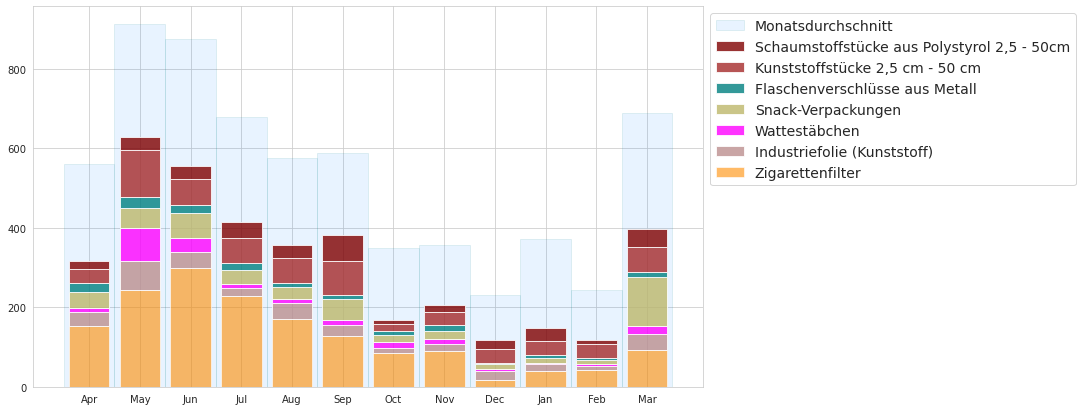

In [17]:
# plot the monthly medidan results for the most common objects
# the code for 2020 is hidden just because it is redundant to see
# slice by survey year
top_ten_month = lks_df[(lks_df["survey year"] == "2018")&(lks_df.code.isin(mcom))].groupby(["loc_date", "date", "code"], as_index=False)[unit_label].sum()
top_ten_month["month"] = top_ten_month.date.dt.month

# copy to work on
dts_date = top_ten_month.copy()
dts_date.set_index("date", inplace=True)

# codes to chart
group_names =  mcom

# a dict to manage all the plots
mgr = {}

# for each of the most common codes resample by month and get the average
for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

# some colors for all the codes
colors_palette = {
    "G156":"dimgray",
    "G178": "teal",
    "G177": "darkslategray",
    "G200": "lightseagreen",
    "G27":"darkorange",
    "G30":"darkkhaki",
    "G67":"rosybrown",
    "G89": "salmon",
    "G95":"magenta",
    "G82": "maroon",
    "G79":"brown",
    "G208": "turquoise",
    "G124":"indigo",
    "G25": "chocolate",
    "G31": "goldenrod",
    "G21": "tan",
    "G198":"teal",
    "G204":"plum"
}

# label the axs
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# plot that
fig, ax = plt.subplots(figsize=(12,7))

def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

# set the bottom of the bar plots
bottom = [0]*len(mgr["G27"])

# average daily total monthly sets the backdrop of the chart
mt = lks_df[lks_df["survey year"] == "2018"].groupby(["loc_date", "date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})
mt.set_index("date", inplace=True)
monthly_total = mt[unit_label].resample("M").mean().fillna(0)

# chart that
this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color=this_palette["2020"], alpha=0.1, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average")

# for each code lay down a box
for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 )
    # if i is not zero add to the bottom
    else:
        bottom += mgr[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# put the handles and labels in the order of the components
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monatsdurchschnitt")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("")
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

<br></br>
*__Unten__ Seen 2020: Durchschnittliche monatliche Umfrageergebnisse häufigste Objekte*  

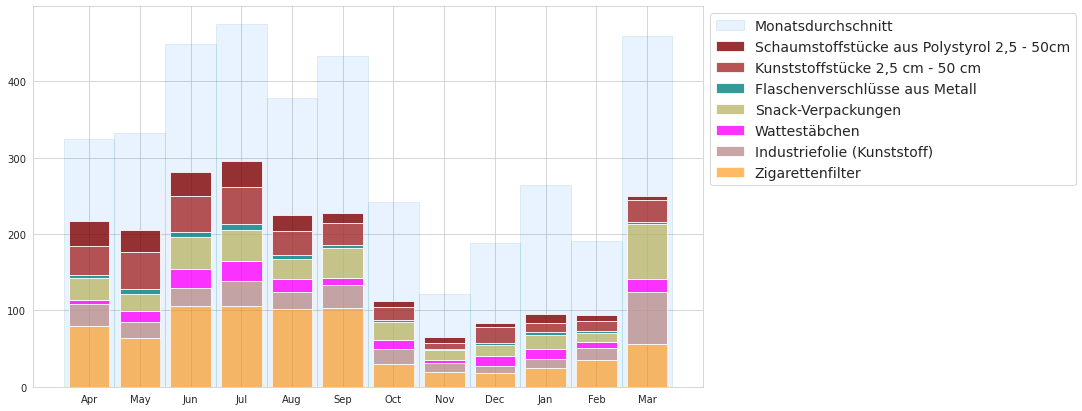

In [18]:
# repeat for 2020
top_ten_month = lks_df[(lks_df["survey year"] == "2020")&(lks_df.code.isin(mcom))].groupby(["loc_date", "date", "code"], as_index=False)["p/100m"].sum()
top_ten_month["month"] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index("date", inplace=True)

mgr2020 = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]["p/100m"].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr2020.update(this_group)
fig, ax = plt.subplots(figsize=(12,7))

bottom = [0]*len(mgr2020["G27"])

mt = lks_df[lks_df["survey year"] == "2020"].groupby(["loc_date", "date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})
mt.set_index("date", inplace=True)
monthly_total = mt[unit_label].resample("M").mean().fillna(0)

this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color=this_palette["2020"], alpha=0.1, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average")

for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr2020[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr2020[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr2020[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6) 
    else:
        bottom += mgr2020[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr2020[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[x-1] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0, "Monatsdurchschnitt")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("", **ck.title_k14)
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

#### Erhebungsorte

In [19]:
# display the survey locations
pd.set_option("display.max_rows", None)

# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[lks_df.location.unique()][disp_columns]
new_names = {"slug":"Standort", "city":"Stadt"}
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns=new_names, inplace=True)
disp_beaches.set_index("Standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,Stadt
Standort,,,
aabach,47.220989,8.940365,Schmerikon
anarchy-beach,46.447216,6.859612,La Tour-de-Peilz
augustmutzenbergstrandweg,46.686640,7.689760,Spiez
baby-plage-geneva,46.208558,6.162923,Genève
baby-plage-ii-geneve,46.208940,6.164330,Genève
bain-des-dames,46.450507,6.858092,La Tour-de-Peilz
baye-de-montreux-g,46.430834,6.908778,Montreux
bielersee_vinelz_fankhausers,47.038398,7.108311,Vinelz
boiron,46.491030,6.480162,Tolochenaz
